# Zero Shot Learning
In this notebook, we give an example of zero shot learning on bubble dataset. We generate the dataset by normal distribution.
We have the follow position per class:
- top left (seen),
- top right (seen),
- bottom left (seen),
- bottom right (seen),
- middle (unseen).

By the above list the only unseen class of the data is at the middle (position). Next we initialize and train a Feed Forward
(FF) neural network for zero shot task. Finally, we visualize the results by cost/score curve and class space.

In [ ]:
from algomorphism.datasets.generated_data import BubbleDataset
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
import algomorphism as am
from sklearn.preprocessing import LabelBinarizer
from algomorphism.figures.nn import pca_denoising_figure
from algomorphism.methods.nn import pca_denoising_preprocessing
from algomorphism.figures.nn import multiple_models_history_figure

In [2]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-26 02:05:34.524748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 02:05:34.533766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 02:05:34.534401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Generate Data
Generate Bubble Dataset and plot some examples.

In [19]:
bd = BubbleDataset(n_data=1000, sigma=0.25)

KNeighborsClassifier(n_neighbors=1)

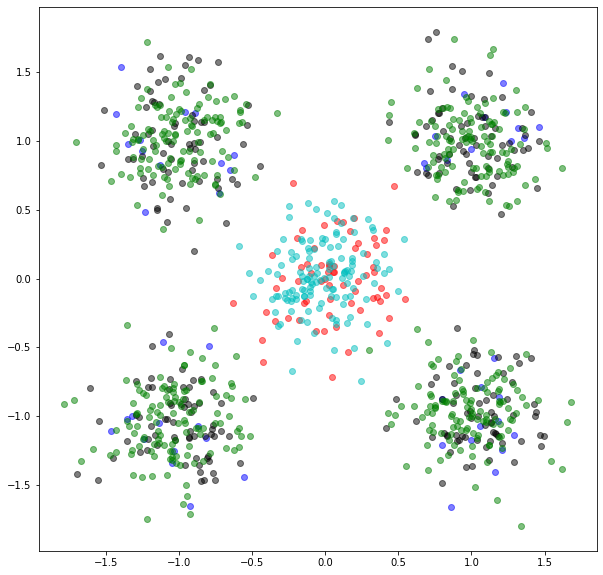

In [20]:
plt.figure(figsize=(10,10))
for x, y, y_hot in bd.val.seen:
    plt.plot(x[:,0], x[:,1], 'ob', alpha=0.5)

for x, y, y_hot in bd.val.unseen:
    plt.plot(x[:,0], x[:,1], 'or', alpha=0.5)

for x, y, y_hot in bd.test.seen:
    plt.plot(x[:,0], x[:,1], 'ok', alpha=0.5)

for x, y, y_hot in bd.test.unseen:
    plt.plot(x[:,0], x[:,1], 'oc', alpha=0.5)

for x, y, y_hot in bd.train:
    plt.plot(x[:,0], x[:,1], 'og', alpha=0.5)

## Initialize 1 Nearest Neighbors Classifier
Train 1 Nearest Neighbors Classifier (1NNC) for post processes of FeedForward output to compute the score.

In [ ]:
knn = KNeighborsClassifier(1)
y_one_hot = LabelBinarizer().fit_transform(list(bd.data_dict.keys()))
knn.fit(
    [v['class_emb'] for v in bd.data_dict.values()],
    y_one_hot
)


## Initialize & Train FF Neural Network

In [21]:
class FeedForward(tf.Module, am.base.BaseNeuralNetwork):
    def __init__(self, knn, dataset):
        tf.Module.__init__(self, name='ff')

        status = [
            [0],
            [1],
            [2]
        ]
        am.base.BaseNeuralNetwork.__init__(self, status=status, optimizer='Adam', dataset=dataset,
                                           learning_rate=1e-2, score_mtr_atr='score')

        self.knn = knn
        self.score_mtr = am.base.MetricBase(self,
                                    [tf.keras.metrics.CategoricalAccuracy()],
                                    status,
                                    [0]
                                    )

        self.cost_mtr = am.base.MetricBase(self,
                                    [tf.keras.metrics.MeanSquaredError()],
                                    status,
                                    [0],
                                    1
                                    )
        self.cost_loss = am.base.LossBase(self,
                                    [tf.keras.losses.MeanSquaredError()],
                                    status,
                                    [0]
                                    )

        self.fc1 = am.layers.FC(2, 128)
        self.fc2 = am.layers.FC(128, 256)
        self.fc3 = am.layers.FC(256, 512)
        self.fc4 = am.layers.FC(512, 1024)
        self.out = am.layers.FC(1024, 2)

    def __call__(self, inputs, is_score=False):
        x = self.fc1(inputs[0])
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        y = self.out(x)
        if is_score:
            y = self.knn.predict(y)
        return tuple([y])

In [22]:
ff = FeedForward(knn=knn, dataset=bd)

In [23]:
ff.train(bd, 60, print_types=['train', 'val'])

Epoch 1 finished
train cost: 54.96332550048828
train score: 0.875
val seen cost: 58.66532897949219
val seen score: 0.9038461446762085
val unseen cost: 8.488611221313477
val unseen score: 0.0
val harmonic: 0.0
Epoch 2 finished
train cost: 5.457016944885254
train score: 0.4729166626930237
val seen cost: 5.943129539489746
val seen score: 0.48076921701431274
val unseen cost: 0.5461822152137756
val unseen score: 0.4545454680919647
val harmonic: 0.4672897458076477
Epoch 3 finished
train cost: 7.567402362823486
train score: 0.17291666567325592
val seen cost: 7.652255535125732
val seen score: 0.11538461595773697
val unseen cost: 3.2869231700897217
val unseen score: 0.0
val harmonic: 0.0
Epoch 4 finished
train cost: 11.197237968444824
train score: 0.5
val seen cost: 12.530980110168457
val seen score: 0.5
val unseen cost: 2.20192813873291
val unseen score: 0.19696970283985138
val harmonic: 0.2826087176799774
Epoch 5 finished
train cost: 4.49956750869751
train score: 0.6979166865348816
val seen c

## Results Visualization
1. Plot cost/score curves for train and validation examples,
2. plot 1KNN space with validation and test outputs of FF.

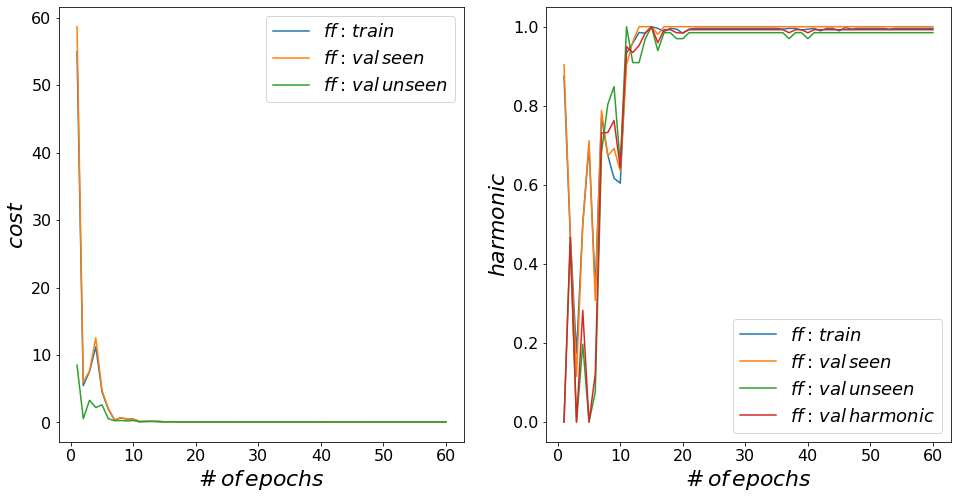

In [24]:
multiple_models_history_figure([ff])

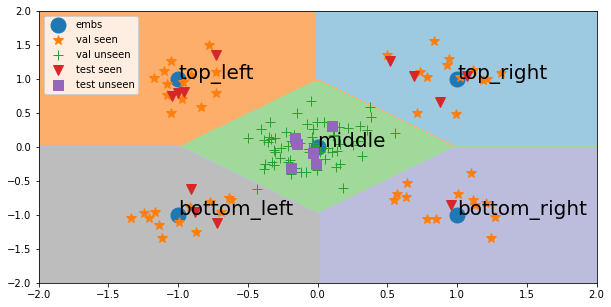

In [25]:
pca_vl_s, pca_ts_s, pca_vl_u, pca_ts_u, pca_emb, knn_pca = pca_denoising_preprocessing(ff, bd,
                                    [v['class_emb'] for v in bd.data_dict.values()], y_one_hot, pca_emb_idxs=[4, 3, 2, 1, 0])

pca_denoising_figure(pca_vl_s, pca_ts_s, pca_vl_u, pca_ts_u, pca_emb, knn_pca,
                     list(bd.data_dict.keys()), pca_emb_idxs=[4, 3, 2, 1, 0])
